In [1]:
#!gcloud compute scp instance-3:~/CIF10/*.npy ~/CF10_Classifier --zone us-central1-c
#  ^ Gets the npy files
#!gcloud compute scp instance-3:~/CIF10/checkpoint ~/CF10_Classifier --zone us-central1-c
#
#!gcloud compute scp instance-3:~/CIF10/CIF10_Classifier* ~/CF10_Classifier --zone us-central1-c
#  ^ Gets the tf files
#!gcloud compute scp ~/Downloads/CIF10_Classifier.py instance-3:~/CIF10 --zone us-central1-c
# ^ uploads this file to cloud

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import skimage as ski
from skimage import io
import skimage.transform
import pickle
import time
import skimage.filters
categories=["Plane","Car","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]
height=32
width=32
depth=3
def perturb_images(image_set,mode=0):
    if mode==0:
        output=[ski.transform.resize(image,[32,32]) for image in image_set]
    elif mode==1:
        shape=image_set[0].shape
        x_seed=np.random.randint(0,shape[0]-32)
        y_seed=np.random.randint(0,shape[1]-32)
        output=[image[x_seed:x_seed+32,y_seed:y_seed+32] for image in image_set]
    elif mode==2:
        output=[image[:,::-1] for image in image_set]
    elif mode==3:
        output=[ski.exposure.adjust_gamma(image) for image in image_set]
    elif mode==4:
        output=[ski.util.random_noise(image) for image in image_set]
    elif mode==5:
        output=[ski.filters.gaussian(image) for image in image_set]
 
    else:
        print("Mode set to %s, out of range" %mode)
        return 0
    if np.shape(output[0])!=(32,32,3):
        output=[ski.transform.resize(image,[56,56,3]) for image in output]
    return output

def classify(input_image):
    if np.shape(input_image)!=(height,width,depth):
        image=ski.transform.resize(input_image,(height,width,depth))
        print("Transformed")
    else:
        image=input_image
    X=sess.run([logits], feed_dict={x: (np.reshape(image,[1,height,width,depth])), y: (np.reshape(0,[1,]))})
    ps = np.exp(X * 1)
    ps /= np.sum(ps)
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(20,10), gridspec_kw = {'width_ratios':[1, 2]})
    ax = axes.ravel()
    print(ps)
    ax[0].imshow(input_image)
    ax[1].bar(np.arange(len(categories)),ps[0][0])
    ax[1].set_xticks(np.arange(len(categories)))
    ax[1].set_xticklabels(categories)
    plt.show()
    

def get_batch(features,labels,batch_size):
    """Selects a training batch from the total set"""
    feature_length=len(features)
    output_features=[]
    output_labels=[]
    for i in range(batch_size):
        element_id=np.random.randint(0,feature_length)
        output_features.append(features[element_id])
        output_labels.append(labels[element_id])
    return output_features,output_labels

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
def load_all_data(path=""):
    output_data,output_labels=[],[]
    for i in range(5):
        name=path+"data_batch_"+str(i+1)
        dictionary=unpickle(name)
        local_data=dictionary[b'data']
        local_labels=dictionary[b'labels']
        local_data=[np.reshape(image,[32,32,3],order="F") for image in local_data]
        output_data=output_data+(local_data)
        output_labels=output_labels+(local_labels)
        print("Done with batch %s" %(i+1))
    name=path+"test_batch"
    test_data=dictionary[b'data']
    test_labels=dictionary[b'labels']
    test_data=[np.reshape(image,[32,32,3],order="F") for image in test_data]

    test_data=[ski.transform.rotate(image,-90) for image in test_data]
    output_data=[ski.transform.rotate(image,-90) for image in output_data]
    return output_data,output_labels,test_data,test_labels
def generate_batch_type(index,test_images,test_labels,batch_size=200,):
    output_images=[]
    for i in range(len(test_images)):
        if test_labels[i]==index:
            output_images.append(test_images[i])
        if len(output_images)==batch_size:
            break
    output_labels=[index]*len(output_images)
    return output_images, output_labels

def detailed_accuracy_report():
    a_list=[]
    for i in range(len(categories)):
        b0,l0=generate_batch_type(i,test_images,test_labels,batch_size=800)
        b0=perturb_images(b0)
        X=sess.run(accuracy, feed_dict={x: b0, y:l0})
        a_list.append(X)
    plt.figure(figsize=[10,5])
    plt.bar(np.arange(len(categories)),a_list)
    plt.xticks(np.arange(len(categories)),categories)
    plt.show()


In [2]:
tf.reset_default_graph()
#
#Here we set up our network.  The best results I was able to obtain were from the architecture:
# 56x56x3 input --> 5x5x32 convolution layer --> 2x2 maxpool layer -> 1024 fully connected layer (relu) -> 3 logits with softmax
# Obviously many other setups are possible, and this code can be changed with a couple keystrokes to add
# another fully connected layer with dropout or another conv-pool set of layers.
# For this problem, due to data scarcity, these additional layers did not contribute positively to the final result
# If training for a long time, however, using the dropout layer was seen to combat overfitting
#
#
# x is the input, y is the output
x = tf.placeholder(dtype = tf.float32, shape = [None, 32, 32,3],name="x_name")
y = tf.placeholder(dtype = tf.int32, shape = [None],name="y_name")
mode = tf.placeholder(dtype = tf.string, shape = (),name="mode_name")
# Setting this mode is important so that learning and dropout may commmence
# The layer structure is described above, implemented here:
input_layer=x
conv1=tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5,5],padding="same",activation=tf.nn.relu)
pool1=tf.layers.max_pooling2d(inputs=conv1,pool_size=[2,2],strides=2)
conv2=tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5,5],padding="same",activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
pool_2_size= int(32 * 32 * 64 / (4 ** 2))   #input image dimensions * filters / (4 ** maxpooling layers)
pool2_flat = tf.reshape(pool2,[-1,pool_2_size])
#pool1_flat = tf.reshape(pool1,[-1,8192])
dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
dropout=tf.layers.dropout(inputs=dense,rate=0.2,training=(mode=="train"))
logits=tf.layers.dense(inputs=dropout,units=10,name="Willy_P")
#z = tf.Variable(logits,name="z_out")
#
#
# The cost function is the standard cross entropy with logits, training stekp is done by AdamOptimizer
Loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits),name="Loss")
train_op = tf.train.AdamOptimizer(learning_rate=0.00005,name="train_op").minimize(Loss)
correct_pred = tf.argmax(logits, 1,name='cp')
accuracy = tf.reduce_mean(tf.cast(tf.equal(correct_pred,tf.cast(y,tf.int64)),tf.float64),name="accuracy")


In [3]:
#
#Below is the code which instantiates the session and performs the training
#A new batch of training data of size "batch_size" will be selected every epoch for "n_epochs" epochs
#
#
st=time.time()
reset_image=False #If true, the input images will be reread from disk
reset_sess=False   #If true, session is reinstantiated and all learned parameters will be discarded
restore_from_backup=True #restore a set of saved parameters
run_train=False       #if true training will commence
save=False
batch_size=2 #sets the number of samples to be considered during each epoch
n_epochs=11        #sets the number of epochs for which the training will run
if reset_image==True:
    train_data,train_labels,test_data,test_labels=load_all_data("cifar-10-batches-py/")

if reset_sess==True:
    tf.set_random_seed(14)
    sess = tf.Session()
    loss_list=[]      #We track the loss and accuracy during training 
    train_acc_list=[]
    test_acc_list=[]
    sess.run(tf.global_variables_initializer())
if restore_from_backup==True:
    tf.reset_default_graph()
    sess=tf.Session()    
    saver = tf.train.import_meta_graph('CIF10.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("x_name:0")
    y = graph.get_tensor_by_name("y_name:0")
    accuracy=graph.get_tensor_by_name("accuracy:0")
    train_op = graph.get_operation_by_name("train_op")
    logits = graph.get_tensor_by_name("Willy_P/BiasAdd:0")
    correct_p=graph.get_tensor_by_name("cp:0")
    mode = graph.get_tensor_by_name("mode_name:0")
    Loss = graph.get_tensor_by_name("Loss:0")
    loss_list=list(np.load("loss_list.npy"))
    train_acc_list=list(np.load("train_acc_list.npy"))
    test_acc_list=list(np.load("test_acc_list.npy"))

    print("Model restored.")
if run_train==True:
    for i in range(n_epochs):
            print('EPOCH', i)

            batch_features,batch_labels = get_batch(train_data,train_labels,batch_size)
            batch_features=perturb_images(batch_features,mode=np.random.randint(2,6))
            _, train_acc,loss = sess.run([train_op, accuracy,Loss], feed_dict={x: batch_features, y: batch_labels,mode:"train"})
            if i % 5 == 0:
                loss_list.append(loss)
                train_acc_list.append(train_acc)

                test_batch_features,test_batch_labels = get_batch(test_data,test_labels,batch_size)
                test_batch_features=perturb_images(test_batch_features)
                test_acc=sess.run([accuracy], feed_dict={x: test_batch_features, y: test_batch_labels,mode:"test"})
                test_acc_list.append(test_acc)
                print("test_acc=%s"%test_acc)
                print("Time since start=%s"%(time.time()-st))
                #print("Loss: ", loss)
                #print("Accuracy val: ", accuracy_val)
            if save==True and i%10==0:
                saver = tf.train.Saver()
                saver.save(sess, 'CIF10')
                print("Model Saved")
                np.save("loss_list",loss_list)
                np.save("train_acc_list",train_acc_list)
                np.save("test_acc_list",test_acc_list)



INFO:tensorflow:Restoring parameters from ./CIF10
Model restored.


loss_list.npy                                 100% 9984     9.8KB/s   00:00    
test_acc_list.npy                             100%   19KB  19.4KB/s   00:00    
train_acc_list.npy                            100%   19KB  19.4KB/s   00:00    


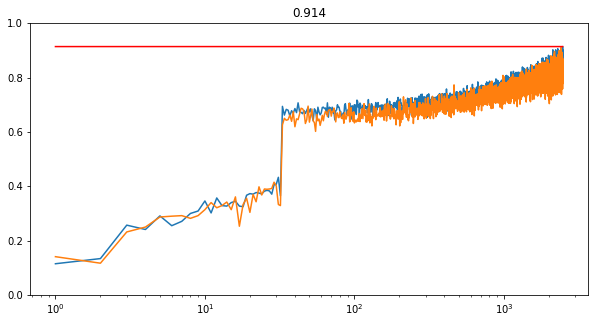

In [3]:
def update_from_cloud():
    !gcloud compute scp instance-3:~/CIF10/*.npy ~/CF10_Classifier --zone us-central1-c
    !gcloud compute scp instance-3:~/CIF10/checkpoint ~/CF10_Classifier --zone us-central1-c
    !gcloud compute scp instance-3:~/CIF10/CIF10.meta ~/CF10_Classifier --zone us-central1-c
    !gcloud compute scp instance-3:~/CIF10/CIF10.index ~/CF10_Classifier --zone us-central1-c
    !gcloud compute scp instance-3:~/CIF10/CIF10.data* ~/CF10_Classifier --zone us-central1-c
def push_py_to_cloud():
    !gcloud compute scp ~/Downloads/CIF10_Classifier.py instance-3:~/CIF10 --zone us-central1-c
def check_on_cloud(reload=True):
    if reload==True:
        !gcloud compute scp instance-3:~/CIF10/*.npy ~/CF10_Classifier --zone us-central1-c
    train_acc_list=np.load("train_acc_list.npy")
    test_acc_list=np.load("test_acc_list.npy")

    plt.figure(figsize=[10,5])
    plt.title((np.max(test_acc_list)))
    plt.plot(test_acc_list)
    plt.semilogx(train_acc_list)
    plt.plot(np.arange(len(train_acc_list)),[np.max(test_acc_list)]*len(train_acc_list),'r-')
    plt.ylim([0,1])
    plt.show()
check_on_cloud(reload=True)

In [4]:
update_from_cloud()

loss_list.npy                                 100% 9984     9.8KB/s   00:00    
test_acc_list.npy                             100%   19KB  19.4KB/s   00:00    
train_acc_list.npy                            100%   19KB  19.4KB/s   00:00    
checkpoint                                    100%   67     0.1KB/s   00:00    
CIF10.meta                                    100%   27MB   9.0MB/s   00:03    
CIF10.index                                   100%  987     1.0KB/s   00:00    
CIF10.data-00000-of-00001                     100%   49MB  16.3MB/s   00:03    


In [ ]:
ts=np.load("test_acc_list.npy")
plt.plot(ts)

In [119]:
ls

CIF10.data-00000-of-00001  checkpoint
CIF10.index                cifar-10-batches-py/
CIF10.meta                 loss_list.npy
CIF10_Classifier.ipynb     test_acc_list.npy
CIF10_Classifier.py        train_acc_list.npy


In [ ]:
ii+=1
image1=test_batch_features[ii]
classify(image1)
#    

In [ ]:
def plot_saliency(input_image):
    io.imshow(input_image)
    plt.show()
    graders=[tf.gradients(logits[0][i],x) for i in range(10)]
    logs, saliency=sess.run([logits,graders], feed_dict={x: [input_image], y: [1],mode:"test"})
    fig, axes = plt.subplots(ncols=5,nrows=2, figsize=(20,10))
    ax = axes.ravel()
    for i in range(10):
        image=ski.color.rgb2gray(saliency[i][0][0])
        thresh = ski.filters.threshold_mean(image)
        binary = image > thresh
        image=image*binary
        ax[i].imshow(image)
        ax[i].set_xlabel("Activation gradients for "+str(categories[i]))
        ax[i].set_ylabel("logit was "+str(logs[0][i]))

    plt.show()

def plot_max_saliency(input_image):
    graders=[tf.gradients(logits[0][i],x) for i in range(10)]
    logs, saliency=sess.run([logits,graders], feed_dict={x: [input_image], y: [1],mode:"test"})
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
    ax = axes.ravel()
    i=np.argmax(logs)
    image=ski.color.rgb2gray(saliency[i][0][0])
    thresh = ski.filters.threshold_mean(image)
    binary = image > thresh
    image=image*binary
    ax[0].imshow(input_image)
    ax[1].imshow(image)
    ax[1].set_xlabel("Activation gradients for "+str(categories[i]))
    ax[1].set_ylabel("logit was "+str(logs[0][i]))

    plt.show()
def pretty_out(input_image):
    if np.shape(input_image)!=(32,32,3):
        input_image=ski.transform.resize(input_image,(32,32,3))
        print("Transformed")
    logs=sess.run([logits], feed_dict={x: [input_image], y: [1],mode:"test"})
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(6,2.5), gridspec_kw = {'width_ratios':[1, 1]})
    ax = axes.ravel()
    print("check1")
    i=np.argmax(logs)
    graders=[tf.gradients(logits[0][i],x)]
    print("subcheck")
    saliency=sess.run([graders], feed_dict={x: [input_image], y: [1],mode:"test"})
    print("check2")
    image=ski.color.rgb2gray(saliency[0][0][0])
    thresh = ski.filters.threshold_mean(image)
    binary = image > thresh
    image=(image*binary)[0]
    print(np.shape(logs))
    ax[0].imshow(input_image)
    ax[1].imshow(image)
    ax[1].set_xlabel("Activation gradients for "+str(categories[i]))
    ax[1].set_ylabel("logit was "+str(logs[0][0][i]))
    print("check3")
    #plt.show()
  
    ps = np.exp(logs[0][0] * 1)
    ps /= np.sum(ps)
    plt.figure(figsize=[6,2.5])
    #print(ps)
    plt.bar(np.arange(len(categories)),ps)
    
    plt.xticks(np.arange(len(categories)),categories)
    #plt.title("%s percent sure" %np.round(100*np.max(ps[0]),1))
    #plt.show()
    #io.imshow(input_image)

    plt.show()

ii+=1
image1=test_batch_features[ii]
pretty_out(image1)
#    

In [ ]:
name="whiskey.png"
image1=plt.imread("/Users/MattHarrison/"+name)
pretty_out(image1)


In [6]:

name="cpic9.jpeg"
image1=plt.imread("/Users/MattHarrison/")
classify(image1)


IsADirectoryError: [Errno 21] Is a directory: '/Users/MattHarrison/'

In [20]:
detailed_accuracy_report()

NameError: name 'test_images' is not defined

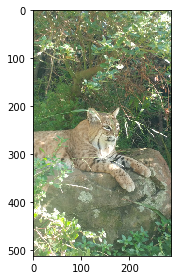

ValueError: Cannot feed value of shape (1, 512, 288, 3) for Tensor 'x_name:0', which has shape '(?, 32, 32, 3)'

In [86]:
plot_saliency(image1)

In [181]:
image=plt.imread('/Users/MattHarrison/cpic1.jpeg')
pretty(image)

NameError: name 'transform' is not defined

In [4]:
    train_data,train_labels,test_data,test_labels=load_all_data("cifar-10-batches-py/")


Done with batch 1
Done with batch 2
Done with batch 3
Done with batch 4
Done with batch 5


In [23]:
test_batch_features,test_batch_labels = get_batch(test_data,test_labels,200)
test_batch_features=perturb_images(test_batch_features)


NameError: name 'test_data' is not defined

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Transformed
[[[  3.42445910e-01   4.20122743e-02   1.45457787e-02   1.01196341e-01
     2.12449068e-03   5.25337458e-03   1.85474535e-04   6.60447171e-03
     1.21215098e-01   3.64416808e-01]]]


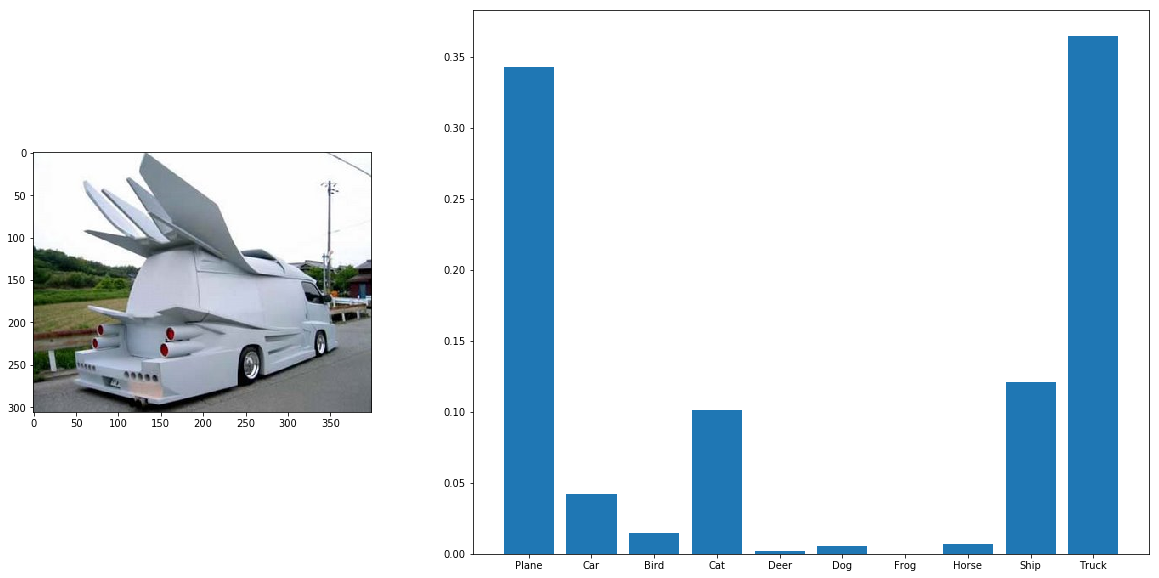

In [6]:
name="vic40.png"
image1=plt.imread("/Users/MattHarrison/"+name)
classify(image1)
